In [2]:
import ssms
import torch
import pickle
import numpy as np
import os
import lanfactory
from copy import deepcopy
import pandas as pd

In [3]:
from os import PathLike
from typing import Callable, Tuple

import pytensor 
pytensor.config.floatX = "float32"
import pytensor.tensor as pt
import jax.numpy as jnp
import numpy as np
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify
from jax import grad, jit
from numpy.typing import ArrayLike

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]

import pymc as pm
from pytensor.tensor.random.op import RandomVariable

import warnings 
warnings.filterwarnings('ignore')

class NetworkLike:
    @classmethod
    def make_logp_jax_funcs(
        cls,
        model = None,
        n_params: int | None = None,
        kind: str = 'lan',
    ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
        """Makes a jax log likelihood function from flax network forward pass.
        Args:
            model: A path or url to the ONNX model, or an ONNX Model object
            already loaded.
            compile: Whether to use jit in jax to compile the model.
        Returns: A triple of jax or Python functions. The first calculates the
            forward pass, the second calculates the gradient, and the third is
            the forward-pass that's not jitted.
        """
        if kind == 'lan':
            def logp_lan(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial by trial likelihoods
                are derived from a LAN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """

                # Makes a matrix to feed to the LAN model
                params_matrix = jnp.repeat(
                    jnp.stack(dist_params[:-1]).reshape(1, -1), axis=0, repeats=data.shape[0]
                )

                # Set 'v' parameters depending on condition
                # params_matrix = params_matrix.at[:, 0].set(params_matrix[:, 0] * data[:, 2])

                # Stack parameters and data to have full input
                input_matrix = jnp.hstack([params_matrix, data[:, :2]])

                ssm_ll = jnp.exp(model(input_matrix))


                # Include lapse distribution (uniform) into (rt,choice) likelihood
                
                full_ll = dist_params[-1] * 1/20 + (1 - dist_params[-1]) * ssm_ll

                # Network forward and sum
                return jnp.sum(
                    jnp.squeeze(jnp.log(full_ll))
                )

            logp_grad_lan = grad(logp_lan, argnums=range(1, 1 + n_params))
            return jit(logp_lan), jit(logp_grad_lan), logp_lan

        elif kind == 'cpn':
            def logp_cpn(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial-by-trial likelihood derive for a CPN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """

                # Makes a matrix to feed to the LAN model
                # n_nogo_go_condition = jnp.sum(data > 0)
                # n_nogo_nogo_condition = jnp.sum(data < 0)
                n_omission = jnp.sum(data>0)
                params_matrix  = jnp.stack(dist_params[:-1]).reshape(1, -1)

                # AF-TODO Bugfix here !
                # dist_params_nogo = jnp.stack(dist_params).reshape(1, -1)
                # dist_params_nogo = dist_params_nogo.at[0].set((-1) * dist_params_nogo[0])

                net_in = params_matrix

                net_out = jnp.squeeze(model(net_in))

                # Include lapse distribution (uniform) into omission likelihood
                # dist_params[-1]: p_outlier
                # dist_params[-2]: deadline (in second)
                # I don't think we should include the p_outlier in this part, because the model will then fit p_outlier to the omission rate
                # Or at least we need to adjust the underlying distribution, which do make things complex.
                out = jnp.log(1 - jnp.exp(net_out) + 1e-64 + dist_params[-1] * (1 - dist_params[-2]/20)) * n_omission

                return out

            logp_grad_cpn = grad(logp_cpn, argnums=range(1, 2 + n_params))
            return jit(logp_cpn), jit(logp_grad_cpn), logp_cpn

    @staticmethod
    def make_jax_logp_ops(
        logp: LogLikeFunc,
        logp_grad: LogLikeGrad,
        logp_nojit: LogLikeFunc,
    ) -> LogLikeFunc:
        """Wraps the JAX functions and its gradient in Pytensor Ops.
        Args:
            logp: A JAX function that represents the feed-forward operation of the
                LAN network.
            logp_grad: The derivative of the above function.
            logp_nojit: A Jax function
        Returns:
            An pytensor op that wraps the feed-forward operation and can be used with
            pytensor.grad.
        """

        class LogpOp(Op):
            """Wraps a JAX function in an pytensor Op."""

            def make_node(self, data, *dist_params):
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]

                outputs = [pt.scalar()]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, output_storage):
                """Performs the Apply node.
                Args:
                    inputs: This is a list of data from which the values stored in
                        output_storage are to be computed using non-symbolic language.
                    output_storage: This is a list of storage cells where the output
                        is to be stored. A storage cell is a one-element list. It is
                        forbidden to change the length of the list(s) contained in
                        output_storage. There is one storage cell for each output of
                        the Op.
                """
                result = logp(*inputs)
                output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

            def grad(self, inputs, output_grads):
                results = lan_logp_grad_op(*inputs)
                output_gradient = output_grads[0]
                return [
                    pytensor.gradient.grad_not_implemented(self, 0, inputs[0]),
                ] + [output_gradient * result for result in results]

        class LogpGradOp(Op):
            """Wraps the gradient opearation of a jax function in an pytensor op."""

            def make_node(self, data, *dist_params):
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]
                outputs = [inp.type() for inp in inputs[1:]]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, outputs):
                results = logp_grad(inputs[0], *inputs[1:])

                for i, result in enumerate(results):
                    outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)

        lan_logp_op = LogpOp()
        lan_logp_grad_op = LogpGradOp()

        # Unwraps the JAX function for sampling with JAX backend.
        @jax_funcify.register(LogpOp) # Can fail in notebooks
        def logp_op_dispatch(op, **kwargs):  # pylint: disable=W0612,W0613
            return logp_nojit

        return lan_logp_op

In [4]:
# Loaded Net
model_config = ssms.config.model_config['angle']

jax_infer_lan = lanfactory.trainers.MLPJaxFactory(
    network_config="/users/xleng/data/xleng/proj_lan_pipeline_minimal/LAN_pipeline_minimal/data/networks/jax/lan/angle/a59e9a36932b11ee8336a0423f39b436_lan_angle__network_config.pickle",
    train=False,
)

forward_pass_lan, forward_pass_jitted_lan = jax_infer_lan.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="/users/xleng/data/xleng/proj_lan_pipeline_minimal/LAN_pipeline_minimal/data/networks/jax/lan/angle/a59e9a36932b11ee8336a0423f39b436_lan_angle__train_state.jax",
    add_jitted=True,
)

I0000 00:00:1703688184.122246   76786 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


passing through identity


In [5]:
# Loaded Net
jax_infer_cpn = lanfactory.trainers.MLPJaxFactory(
    network_config="/users/xleng/data/xleng/proj_lan_pipeline_minimal/LAN_pipeline_minimal/data/networks/jax/cpn/angle/9b7fdb6e94a711ee8b09a0423f3e9b42_cpn_angle__network_config.pickle",
    train=False,
)

forward_pass_cpn, forward_pass_jitted_cpn = jax_infer_cpn.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 1,
    state="/users/xleng/data/xleng/proj_lan_pipeline_minimal/LAN_pipeline_minimal/data/networks/jax/cpn/angle/9b7fdb6e94a711ee8b09a0423f3e9b42_cpn_angle__train_state.jax",
    add_jitted=True,
)

passing through transform


In [6]:
# Instantiate LAN logp functions
lan_logp_jitted, lan_logp_grad_jitted, lan_logp = NetworkLike.make_logp_jax_funcs(
                                                                                                 model = forward_pass_lan,
                                                                                                 n_params = 4,
                                                                                                 kind = "lan")

# Turn into logp op
lan_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = lan_logp_jitted,
                                logp_grad = lan_logp_grad_jitted,
                                logp_nojit = lan_logp)

# Instantiate CPN logp functions
cpn_logp_jitted, cpn_logp_grad_jitted, cpn_logp = NetworkLike.make_logp_jax_funcs(
                                                                                                    model = forward_pass_cpn,
                                                                                                    n_params = 4,
                                                                                                    kind = "cpn")

# Turn into logp op
cpn_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = cpn_logp_jitted,
                                logp_grad = cpn_logp_grad_jitted,
                                logp_nojit = cpn_logp)

In [7]:
from pymc.sampling import jax as pmj

# Just to keep the blog-post pretty automatically
import warnings 
warnings.filterwarnings('ignore')


a_list  = np.linspace(1,2,5)
theta_list  = np.linspace(0.2,1.2,5)
# Test parameters:
# v, z, t, deadline = 2, 0.5, 0.3, 1.25

a_true = []
theta_true = []

a_pred_nd = []
theta_pred_nd = []

a_pred_d = []
theta_pred_d = []

omission_list = []

for a in a_list:
    for theta in theta_list:
        v, z, t, deadline = 1, 0.5, 0.3, 1.25
        a_true.append(a)
        theta_true.append(theta)

        # Comparison simulator run
        sim_out = ssms.basic_simulators.simulator.simulator(
            model='angle', theta=[v, a, z, t, theta], n_samples=1000
        )
        data = np.hstack([sim_out['rts'], sim_out['choices']]).astype(np.float32)
        data_commission = data[data[:,0]<deadline,:]
        data_omission = data[:,0]>=deadline
        data_omission = data_omission.astype(np.float32)
        omission_rate = np.mean(data_omission)

        omission_list.append(omission_rate)
        
        with pm.Model() as ddm:
            # Define simple Uniform priors
            v1 = pm.Uniform("v", -3.0, 3.0)
            a1 = pm.Uniform("a", 0.3, 2.5)
            z = pt.constant(0.5)
            t = pm.Uniform("t", 0.0, 2.0)
            theta =pm.Uniform("theta", 0.0, 1.2)
            deadline = pt.constant(1.25)
            p_outlier = pm.Uniform("p_outlier", 0.0, 0.1)
            # t = pm.Uniform("t", 0.0, 2.0)
            # theta = pm.Uniform("theta",0,1.3)
            # ddl = pt.constant(1.25)
            
        
            pm.Potential("choice_rt", lan_logp_op(data_commission, v1, a1, z, t, theta,p_outlier))
            #pm.Potential("omission", cpn_logp_op(data_omission, v1, a1, z, t, theta,deadline))
        
            ddm_blog_traces_numpyro = pmj.sample_numpyro_nuts(
                    chains=2, draws=2000, tune=1000,target_accept=0.9
                    )
            post_summary = pm.summary(ddm_blog_traces_numpyro)

        a_pred_nd.append(post_summary.loc['a','mean'])
        theta_pred_nd.append(post_summary.loc['theta','mean'])
        

        with pm.Model() as ddm:
            # Define simple Uniform priors
            v1 = pm.Uniform("v", -3.0, 3.0)
            a1 = pm.Uniform("a", 0.3, 2.5)
            z = pt.constant(0.5)
            t = pm.Uniform("t", 0.0, 2.0)
            theta =pm.Uniform("theta", 0.0, 1.2)
            deadline = pt.constant(1.25)
            p_outlier = pm.Uniform("p_outlier", 0.0, 0.1)
            # t = pm.Uniform("t", 0.0, 2.0)
            # theta = pm.Uniform("theta",0,1.3)
            # ddl = pt.constant(1.25)
            
        
            pm.Potential("choice_rt", lan_logp_op(data_commission, v1, a1, z, t, theta,p_outlier))
            pm.Potential("omission", cpn_logp_op(data_omission, v1, a1, z, t, theta,deadline,p_outlier))
        
            ddm_blog_traces_numpyro = pmj.sample_numpyro_nuts(
                    chains=2, draws=2000, tune=1000,target_accept=0.9
                    )
            post_summary = pm.summary(ddm_blog_traces_numpyro)     
        a_pred_d.append(post_summary.loc['a','mean'])
        theta_pred_d.append(post_summary.loc['theta','mean'])

Compiling...


passing through identity


Compilation time = 0:00:01.859019
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:14<00:00, 40.39it/s, 15 steps of size 1.72e-01. acc. prob=0.93]


passing through identity


sample: 100%|██████████| 3000/3000 [01:18<00:00, 38.17it/s, 15 steps of size 1.48e-01. acc. prob=0.95]
Sampling time = 0:02:35.072480
Transforming variables...
Transformation time = 0:00:00.231964
Compiling...


passing through transform


Compilation time = 0:00:01.229570
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:31<00:00, 32.93it/s, 15 steps of size 1.50e-01. acc. prob=0.95]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:26<00:00, 34.82it/s, 15 steps of size 1.54e-01. acc. prob=0.94]
Sampling time = 0:02:58.188320
Transforming variables...
Transformation time = 0:00:00.198108
Compiling...


passing through identity


Compilation time = 0:00:01.238779
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:42<00:00, 29.37it/s, 31 steps of size 1.25e-01. acc. prob=0.96]


passing through identity


sample: 100%|██████████| 3000/3000 [02:07<00:00, 23.62it/s, 31 steps of size 1.35e-01. acc. prob=0.95]
Sampling time = 0:03:50.088314
Transforming variables...
Transformation time = 0:00:00.250911
Compiling...
Compilation time = 0:00:01.712419
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:47<00:00, 27.97it/s, 31 steps of size 2.07e-01. acc. prob=0.93]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:27<00:00, 34.28it/s, 15 steps of size 2.13e-01. acc. prob=0.93]
Sampling time = 0:03:15.277533
Transforming variables...
Transformation time = 0:00:00.171372
Compiling...


passing through identity


Compilation time = 0:00:01.419826
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:48<00:00, 27.56it/s, 31 steps of size 1.25e-01. acc. prob=0.96]


passing through identity


sample: 100%|██████████| 3000/3000 [02:02<00:00, 24.42it/s, 31 steps of size 1.02e-01. acc. prob=0.97]
Sampling time = 0:03:52.605431
Transforming variables...
Transformation time = 0:00:00.197329
Compiling...
Compilation time = 0:00:01.107532
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:08<00:00, 23.37it/s, 3 steps of size 1.11e-01. acc. prob=0.96] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:04<00:00, 24.14it/s, 31 steps of size 1.01e-01. acc. prob=0.96]
Sampling time = 0:04:13.111865
Transforming variables...
Transformation time = 0:00:00.173179
Compiling...
Compilation time = 0:00:01.065716
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:53<00:00, 26.43it/s, 47 steps of size 1.11e-01. acc. prob=0.96]


passing through identity


sample: 100%|██████████| 3000/3000 [01:39<00:00, 30.17it/s, 31 steps of size 1.36e-01. acc. prob=0.94]
Sampling time = 0:03:33.355294
Transforming variables...
Transformation time = 0:00:00.176805
Compiling...
Compilation time = 0:00:01.389644
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:52<00:00, 26.74it/s, 31 steps of size 1.24e-01. acc. prob=0.95]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:54<00:00, 26.29it/s, 31 steps of size 1.24e-01. acc. prob=0.96] 
Sampling time = 0:03:46.772553
Transforming variables...
Transformation time = 0:00:00.177665
Compiling...
Compilation time = 0:00:01.080915
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:30<00:00, 19.98it/s, 31 steps of size 1.00e-01. acc. prob=0.94] 


passing through identity


sample: 100%|██████████| 3000/3000 [02:15<00:00, 22.12it/s, 23 steps of size 1.05e-01. acc. prob=0.94] 
Sampling time = 0:04:46.205547
Transforming variables...
Transformation time = 0:00:00.210941
Compiling...
Compilation time = 0:00:01.098654
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [03:00<00:00, 16.64it/s, 31 steps of size 7.84e-02. acc. prob=0.97] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:59<00:00, 16.73it/s, 63 steps of size 6.71e-02. acc. prob=0.97] 
Sampling time = 0:06:00.151621
Transforming variables...
Transformation time = 0:00:00.172943
Compiling...


passing through identity


Compilation time = 0:00:01.473752
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:06<00:00, 23.78it/s, 63 steps of size 7.01e-02. acc. prob=0.97] 


passing through identity


sample: 100%|██████████| 3000/3000 [01:25<00:00, 35.06it/s, 23 steps of size 1.14e-01. acc. prob=0.88]
Sampling time = 0:03:32.656395
Transforming variables...
Transformation time = 0:00:00.204261
Compiling...
Compilation time = 0:00:01.097358
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:41<00:00, 29.54it/s, 63 steps of size 8.67e-02. acc. prob=0.95] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:36<00:00, 31.11it/s, 55 steps of size 1.06e-01. acc. prob=0.97]
Sampling time = 0:03:18.501838
Transforming variables...
Transformation time = 0:00:00.197689
Compiling...


passing through identity


Compilation time = 0:00:01.195875
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:47<00:00, 27.87it/s, 31 steps of size 1.02e-01. acc. prob=0.91]


passing through identity


sample: 100%|██████████| 3000/3000 [02:01<00:00, 24.71it/s, 23 steps of size 7.36e-02. acc. prob=0.97] 
Sampling time = 0:03:49.963363
Transforming variables...
Transformation time = 0:00:00.210187
Compiling...
Compilation time = 0:00:01.440672
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:08<00:00, 43.77it/s, 27 steps of size 1.99e-01. acc. prob=0.95]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:10<00:00, 42.41it/s, 7 steps of size 1.64e-01. acc. prob=0.97] 
Sampling time = 0:02:19.796355
Transforming variables...
Transformation time = 0:00:00.192888
Compiling...


passing through identity


Compilation time = 0:00:01.187039
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:14<00:00, 22.24it/s, 31 steps of size 8.85e-02. acc. prob=0.94] 


passing through identity


sample: 100%|██████████| 3000/3000 [02:21<00:00, 21.26it/s, 31 steps of size 7.97e-02. acc. prob=0.96] 
Sampling time = 0:04:36.925673
Transforming variables...
Transformation time = 0:00:00.183304
Compiling...
Compilation time = 0:00:01.452047
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:18<00:00, 38.03it/s, 7 steps of size 1.88e-01. acc. prob=0.94] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:30<00:00, 33.30it/s, 31 steps of size 1.57e-01. acc. prob=0.95]
Sampling time = 0:02:49.495705
Transforming variables...
Transformation time = 0:00:00.174873
Compiling...
Compilation time = 0:00:01.426402
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [03:05<00:00, 16.20it/s, 63 steps of size 7.31e-02. acc. prob=0.95] 


passing through identity


sample: 100%|██████████| 3000/3000 [03:53<00:00, 12.87it/s, 31 steps of size 4.98e-02. acc. prob=0.97] 
Sampling time = 0:06:58.632294
Transforming variables...
Transformation time = 0:00:00.213095
Compiling...
Compilation time = 0:00:01.083012
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [03:47<00:00, 13.17it/s, 15 steps of size 6.34e-02. acc. prob=0.87] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:47<00:00, 17.88it/s, 47 steps of size 8.41e-02. acc. prob=0.92]
Sampling time = 0:06:36.071381
Transforming variables...
Transformation time = 0:00:00.221852
Compiling...
Compilation time = 0:00:01.477467
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [03:06<00:00, 16.09it/s, 63 steps of size 6.79e-02. acc. prob=0.98] 


passing through identity


sample: 100%|██████████| 3000/3000 [02:23<00:00, 20.92it/s, 31 steps of size 1.02e-01. acc. prob=0.96]
Sampling time = 0:05:30.292556
Transforming variables...
Transformation time = 0:00:00.203875
Compiling...
Compilation time = 0:00:01.077706
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:27<00:00, 20.32it/s, 47 steps of size 1.06e-01. acc. prob=0.94]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:43<00:00, 18.39it/s, 31 steps of size 8.38e-02. acc. prob=0.96] 
Sampling time = 0:05:11.271662
Transforming variables...
Transformation time = 0:00:00.210221
Compiling...


passing through identity


Compilation time = 0:00:01.577867
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [00:54<00:00, 55.30it/s, 15 steps of size 1.78e-01. acc. prob=0.89]


passing through identity


sample: 100%|██████████| 3000/3000 [00:49<00:00, 60.31it/s, 7 steps of size 2.12e-01. acc. prob=0.88] 
Sampling time = 0:01:44.923646
Transforming variables...
Transformation time = 0:00:00.179720
Compiling...
Compilation time = 0:00:01.095026
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:18<00:00, 38.17it/s, 31 steps of size 1.18e-01. acc. prob=0.97]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:00<00:00, 49.65it/s, 31 steps of size 1.72e-01. acc. prob=0.95]
Sampling time = 0:02:19.544601
Transforming variables...
Transformation time = 0:00:00.193337
Compiling...
Compilation time = 0:00:01.095058
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:27<00:00, 34.28it/s, 15 steps of size 1.23e-01. acc. prob=0.94]


passing through identity


sample: 100%|██████████| 3000/3000 [01:24<00:00, 35.61it/s, 31 steps of size 1.09e-01. acc. prob=0.97]
Sampling time = 0:02:52.215243
Transforming variables...
Transformation time = 0:00:00.212350
Compiling...
Compilation time = 0:00:01.084109
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [00:50<00:00, 58.94it/s, 7 steps of size 2.77e-01. acc. prob=0.92] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [00:53<00:00, 55.97it/s, 15 steps of size 2.20e-01. acc. prob=0.95]
Sampling time = 0:01:45.029267
Transforming variables...
Transformation time = 0:00:00.203429
Compiling...


passing through identity


Compilation time = 0:00:01.182739
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:29<00:00, 20.13it/s, 31 steps of size 7.20e-02. acc. prob=0.95] 


passing through identity


sample: 100%|██████████| 3000/3000 [01:44<00:00, 28.70it/s, 31 steps of size 1.16e-01. acc. prob=0.84]
Sampling time = 0:04:14.558842
Transforming variables...
Transformation time = 0:00:00.231293
Compiling...
Compilation time = 0:00:01.509505
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:11<00:00, 41.95it/s, 31 steps of size 1.75e-01. acc. prob=0.97]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:02<00:00, 47.80it/s, 15 steps of size 2.26e-01. acc. prob=0.94]
Sampling time = 0:02:14.825028
Transforming variables...
Transformation time = 0:00:00.212045
Compiling...


passing through identity


Compilation time = 0:00:01.193652
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [03:52<00:00, 12.90it/s, 3 steps of size 4.23e-02. acc. prob=0.87]  


passing through identity


sample: 100%|██████████| 3000/3000 [02:48<00:00, 17.83it/s, 31 steps of size 8.07e-02. acc. prob=0.82] 
Sampling time = 0:06:41.822028
Transforming variables...
Transformation time = 0:00:00.217411
Compiling...
Compilation time = 0:00:01.469704
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [03:47<00:00, 13.21it/s, 63 steps of size 5.05e-02. acc. prob=0.92] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [03:00<00:00, 16.65it/s, 23 steps of size 7.33e-02. acc. prob=0.90] 
Sampling time = 0:06:47.735272
Transforming variables...
Transformation time = 0:00:00.187022
Compiling...
Compilation time = 0:00:01.113137
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:52<00:00, 17.40it/s, 63 steps of size 8.80e-02. acc. prob=0.92] 


passing through identity


sample: 100%|██████████| 3000/3000 [02:57<00:00, 16.88it/s, 63 steps of size 6.62e-02. acc. prob=0.96] 
Sampling time = 0:05:50.582291
Transforming variables...
Transformation time = 0:00:00.202236
Compiling...
Compilation time = 0:00:01.531712
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:21<00:00, 21.19it/s, 27 steps of size 1.06e-01. acc. prob=0.89] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:31<00:00, 19.85it/s, 11 steps of size 1.02e-01. acc. prob=0.93] 
Sampling time = 0:04:53.306444
Transforming variables...
Transformation time = 0:00:00.219140
Compiling...


passing through identity


Compilation time = 0:00:01.215325
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [00:42<00:00, 70.56it/s, 15 steps of size 1.81e-01. acc. prob=0.93]


passing through identity


sample: 100%|██████████| 3000/3000 [00:42<00:00, 69.82it/s, 7 steps of size 1.65e-01. acc. prob=0.95] 
Sampling time = 0:01:26.415581
Transforming variables...
Transformation time = 0:00:00.220415
Compiling...
Compilation time = 0:00:01.081434
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [00:59<00:00, 50.56it/s, 15 steps of size 1.51e-01. acc. prob=0.96]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [00:48<00:00, 61.54it/s, 7 steps of size 1.79e-01. acc. prob=0.93] 
Sampling time = 0:01:48.601007
Transforming variables...
Transformation time = 0:00:00.204327
Compiling...


passing through identity


Compilation time = 0:00:01.177040
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:06<00:00, 45.12it/s, 31 steps of size 1.38e-01. acc. prob=0.96]


passing through identity


sample: 100%|██████████| 3000/3000 [00:57<00:00, 52.29it/s, 15 steps of size 1.48e-01. acc. prob=0.93] 
Sampling time = 0:02:04.800647
Transforming variables...
Transformation time = 0:00:00.218881
Compiling...
Compilation time = 0:00:01.096185
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:16<00:00, 39.21it/s, 3 steps of size 1.41e-01. acc. prob=0.92] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:00<00:00, 49.89it/s, 15 steps of size 2.01e-01. acc. prob=0.85]
Sampling time = 0:02:17.176440
Transforming variables...
Transformation time = 0:00:00.222470
Compiling...


passing through identity


Compilation time = 0:00:01.172304
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:29<00:00, 33.57it/s, 31 steps of size 1.11e-01. acc. prob=0.97]


passing through identity


sample: 100%|██████████| 3000/3000 [01:08<00:00, 43.62it/s, 15 steps of size 1.66e-01. acc. prob=0.84] 
Sampling time = 0:02:39.101831
Transforming variables...
Transformation time = 0:00:00.191006
Compiling...
Compilation time = 0:00:01.100159
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:00<00:00, 49.70it/s, 31 steps of size 1.97e-01. acc. prob=0.96]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [00:54<00:00, 55.20it/s, 15 steps of size 2.42e-01. acc. prob=0.95]
Sampling time = 0:01:55.242063
Transforming variables...
Transformation time = 0:00:00.211762
Compiling...


passing through identity


Compilation time = 0:00:01.170199
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:27<00:00, 20.37it/s, 31 steps of size 8.07e-02. acc. prob=0.97]


passing through identity


sample: 100%|██████████| 3000/3000 [02:11<00:00, 22.75it/s, 63 steps of size 9.07e-02. acc. prob=0.93]
Sampling time = 0:04:40.121721
Transforming variables...
Transformation time = 0:00:00.194734
Compiling...
Compilation time = 0:00:01.130133
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [03:42<00:00, 13.51it/s, 31 steps of size 5.94e-02. acc. prob=0.94] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [04:13<00:00, 11.84it/s, 31 steps of size 4.43e-02. acc. prob=0.95] 
Sampling time = 0:07:56.024294
Transforming variables...
Transformation time = 0:00:00.217856
Compiling...
Compilation time = 0:00:01.095168
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [02:10<00:00, 23.05it/s, 31 steps of size 1.17e-01. acc. prob=0.92]


passing through identity


sample: 100%|██████████| 3000/3000 [02:30<00:00, 19.88it/s, 31 steps of size 8.40e-02. acc. prob=0.97]
Sampling time = 0:04:41.506335
Transforming variables...
Transformation time = 0:00:00.211588
Compiling...
Compilation time = 0:00:01.109425
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:28<00:00, 20.25it/s, 63 steps of size 8.57e-02. acc. prob=0.97]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:42<00:00, 18.51it/s, 31 steps of size 9.19e-02. acc. prob=0.96] 
Sampling time = 0:05:10.816023
Transforming variables...
Transformation time = 0:00:00.219544
Compiling...


passing through identity


Compilation time = 0:00:01.184363
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [00:48<00:00, 61.97it/s, 15 steps of size 1.08e-01. acc. prob=0.97]


passing through identity


sample: 100%|██████████| 3000/3000 [00:42<00:00, 70.43it/s, 31 steps of size 1.33e-01. acc. prob=0.96]
Sampling time = 0:01:31.968554
Transforming variables...
Transformation time = 0:00:00.676038
Compiling...
Compilation time = 0:00:01.093899
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:04<00:00, 46.29it/s, 15 steps of size 9.49e-02. acc. prob=0.95] 


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [00:56<00:00, 52.85it/s, 31 steps of size 1.15e-01. acc. prob=0.94]
Sampling time = 0:02:02.090824
Transforming variables...
Transformation time = 0:00:00.213974
Compiling...


passing through identity


Compilation time = 0:00:01.187682
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [00:49<00:00, 60.50it/s, 15 steps of size 1.53e-01. acc. prob=0.95]


passing through identity


sample: 100%|██████████| 3000/3000 [00:50<00:00, 59.22it/s, 31 steps of size 1.20e-01. acc. prob=0.98]
Sampling time = 0:01:41.185791
Transforming variables...
Transformation time = 0:00:00.204875
Compiling...
Compilation time = 0:00:01.559101
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:11<00:00, 41.77it/s, 31 steps of size 1.03e-01. acc. prob=0.97]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:06<00:00, 45.05it/s, 31 steps of size 1.26e-01. acc. prob=0.95]
Sampling time = 0:02:18.943889
Transforming variables...
Transformation time = 0:00:00.205709
Compiling...


passing through identity


Compilation time = 0:00:01.180079
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:13<00:00, 41.09it/s, 31 steps of size 1.30e-01. acc. prob=0.93]


passing through identity


sample: 100%|██████████| 3000/3000 [01:06<00:00, 45.18it/s, 23 steps of size 1.35e-01. acc. prob=0.92]
Sampling time = 0:02:20.333003
Transforming variables...
Transformation time = 0:00:00.205365
Compiling...
Compilation time = 0:00:01.572068
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:21<00:00, 36.60it/s, 31 steps of size 1.30e-01. acc. prob=0.96]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:35<00:00, 31.36it/s, 31 steps of size 8.72e-02. acc. prob=0.94] 
Sampling time = 0:02:58.141244
Transforming variables...
Transformation time = 0:00:00.216546
Compiling...


passing through identity


Compilation time = 0:00:01.172454
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:50<00:00, 27.18it/s, 31 steps of size 1.00e-01. acc. prob=0.95]


passing through identity


sample: 100%|██████████| 3000/3000 [01:43<00:00, 28.93it/s, 31 steps of size 1.21e-01. acc. prob=0.94]
Sampling time = 0:03:34.995350
Transforming variables...
Transformation time = 0:00:00.175779
Compiling...
Compilation time = 0:00:01.598665
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [02:32<00:00, 19.66it/s, 23 steps of size 7.80e-02. acc. prob=0.97]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:41<00:00, 29.47it/s, 15 steps of size 1.22e-01. acc. prob=0.94]
Sampling time = 0:04:14.948628
Transforming variables...
Transformation time = 0:00:00.205607
Compiling...
Compilation time = 0:00:01.104810
Sampling...


passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 3000/3000 [01:56<00:00, 25.68it/s, 31 steps of size 1.39e-01. acc. prob=0.95]


passing through identity


sample: 100%|██████████| 3000/3000 [01:50<00:00, 27.04it/s, 15 steps of size 1.50e-01. acc. prob=0.92]
Sampling time = 0:03:48.224914
Transforming variables...
Transformation time = 0:00:00.182520
Compiling...
Compilation time = 0:00:01.110019
Sampling...


passing through transform
passing through identity


  0%|          | 0/3000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:56<00:00, 25.75it/s, 31 steps of size 1.37e-01. acc. prob=0.94]


passing through transform
passing through identity


sample: 100%|██████████| 3000/3000 [01:49<00:00, 27.32it/s, 31 steps of size 1.31e-01. acc. prob=0.95]
Sampling time = 0:03:46.860069
Transforming variables...
Transformation time = 0:00:00.212493


In [9]:
import matplotlib.pyplot as plt

In [10]:
a_pred_nd

[1.104,
 1.05,
 0.985,
 0.953,
 0.954,
 2.319,
 2.341,
 1.381,
 2.235,
 1.124,
 2.436,
 2.439,
 2.403,
 2.32,
 1.379,
 2.433,
 2.448,
 2.449,
 2.436,
 1.648,
 2.42,
 2.443,
 2.439,
 2.451,
 1.928]

In [11]:
theta_true

[0.2,
 0.45,
 0.7,
 0.95,
 1.2,
 0.2,
 0.45,
 0.7,
 0.95,
 1.2,
 0.2,
 0.45,
 0.7,
 0.95,
 1.2,
 0.2,
 0.45,
 0.7,
 0.95,
 1.2,
 0.2,
 0.45,
 0.7,
 0.95,
 1.2]

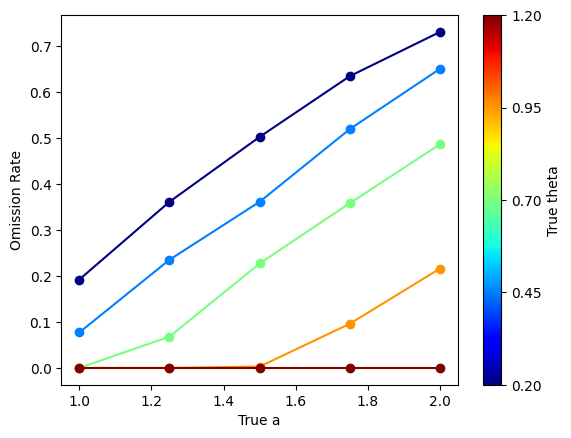

In [12]:
n_lines = len(theta_list)
c = np.arange(1, n_lines + 1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=theta_list[0], vmax=theta_list[4])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
"""
fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))
fig.colorbar(cmap, ticks=c)
plt.show();
"""
fig, ax = plt.subplots(dpi=100)
for i,theta in enumerate(theta_list):
    mask = np.array(theta_true)==theta
    a_true_sub = np.array(a_true)[mask]
    or_sub = np.array(omission_list)[mask]
    #plt.scatter(a_true_sub,a_pred_d_sub)
    ax.plot(a_true_sub,or_sub,linestyle='-', marker='o',color=cmap.to_rgba(theta))
plt.colorbar(cmap,ax=ax,ticks=theta_list,label='True theta')
# ax.plot(a_true_sub,a_true_sub,linestyle='--', color='black')
plt.xlabel('True a')
plt.ylabel('Omission Rate')
plt.show()

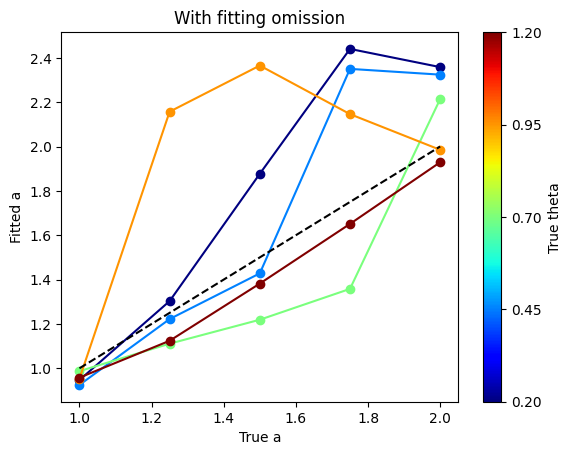

In [13]:
n_lines = len(theta_list)
c = np.arange(1, n_lines + 1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=theta_list[0], vmax=theta_list[4])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
"""
fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))
fig.colorbar(cmap, ticks=c)
plt.show();
"""
fig, ax = plt.subplots(dpi=100)
for i,theta in enumerate(theta_list):
    mask = np.array(theta_true)==theta
    a_true_sub = np.array(a_true)[mask]
    a_pred_d_sub = np.array(a_pred_d)[mask]
    #plt.scatter(a_true_sub,a_pred_d_sub)
    ax.plot(a_true_sub,a_pred_d_sub,linestyle='-', marker='o',color=cmap.to_rgba(theta))
plt.colorbar(cmap,ax=ax,ticks=theta_list,label='True theta')
ax.plot(a_true_sub,a_true_sub,linestyle='--', color='black')
plt.xlabel('True a')
plt.ylabel('Fitted a')
plt.title('With fitting omission')
plt.show()

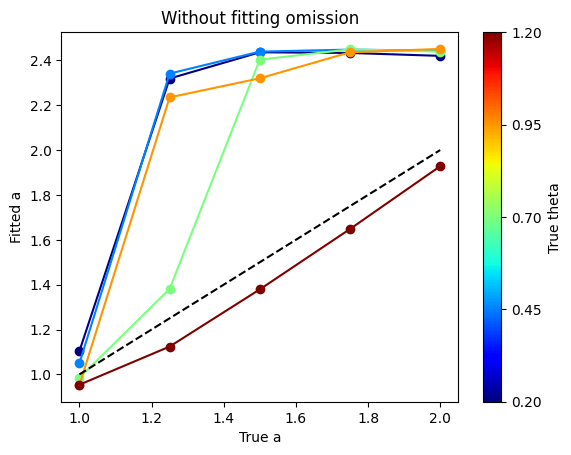

In [14]:
n_lines = len(theta_list)
c = np.arange(1, n_lines + 1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=theta_list[0], vmax=theta_list[4])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
"""
fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))
fig.colorbar(cmap, ticks=c)
plt.show();
"""
fig, ax = plt.subplots(dpi=100)
for i,theta in enumerate(theta_list):
    mask = np.array(theta_true)==theta
    a_true_sub = np.array(a_true)[mask]
    a_pred_nd_sub = np.array(a_pred_nd)[mask]
    #plt.scatter(a_true_sub,a_pred_d_sub)
    ax.plot(a_true_sub,a_pred_nd_sub,linestyle='-', marker='o',color=cmap.to_rgba(theta))
plt.colorbar(cmap,ax=ax,ticks=theta_list,label='True theta')
ax.plot(a_true_sub,a_true_sub,linestyle='--', color='black')
plt.xlabel('True a')
plt.ylabel('Fitted a')
plt.title('Without fitting omission')
plt.show()


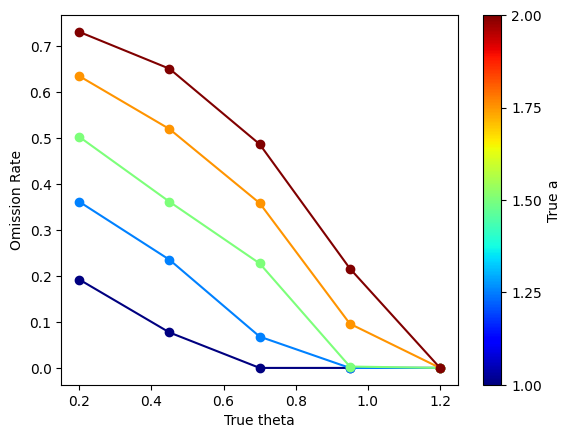

In [15]:
n_lines = len(theta_list)
c = np.arange(1, n_lines + 1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=a_list[0], vmax=a_list[4])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
"""
fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))
fig.colorbar(cmap, ticks=c)
plt.show();
"""
fig, ax = plt.subplots(dpi=100)
for i,a in enumerate(a_list):
    mask = np.array(a_true)==a
    theta_true_sub = np.array(theta_true)[mask]
    or_sub = np.array(omission_list)[mask]
    #plt.scatter(a_true_sub,a_pred_d_sub)
    ax.plot(theta_true_sub,or_sub,linestyle='-', marker='o',color=cmap.to_rgba(a))
plt.colorbar(cmap,ax=ax,ticks=a_list,label='True a')
# ax.plot(a_true_sub,a_true_sub,linestyle='--', color='black')
plt.xlabel('True theta')
plt.ylabel('Omission Rate')
plt.show()

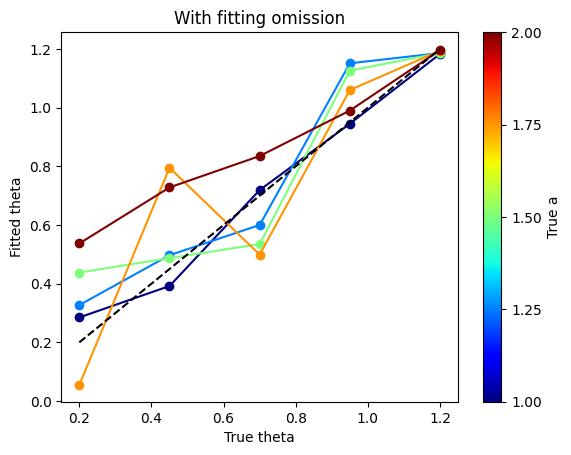

In [16]:
n_lines = len(a_list)
c = np.arange(1, n_lines + 1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=a_list[0], vmax=a_list[4])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
"""
fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))
fig.colorbar(cmap, ticks=c)
plt.show();
"""
fig, ax = plt.subplots(dpi=100)
for i,a in enumerate(a_list):
    mask = np.array(a_true)==a
    theta_true_sub = np.array(theta_true)[mask]
    theta_pred_d_sub = np.array(theta_pred_d)[mask]
    #plt.scatter(a_true_sub,a_pred_d_sub)
    ax.plot(theta_true_sub,theta_pred_d_sub,linestyle='-', marker='o',color=cmap.to_rgba(a))
plt.colorbar(cmap,ax=ax,ticks=a_list,label='True a')
ax.plot(theta_true_sub,theta_true_sub,linestyle='--', color='black')
plt.xlabel('True theta')
plt.ylabel('Fitted theta')
plt.title('With fitting omission')
plt.show()

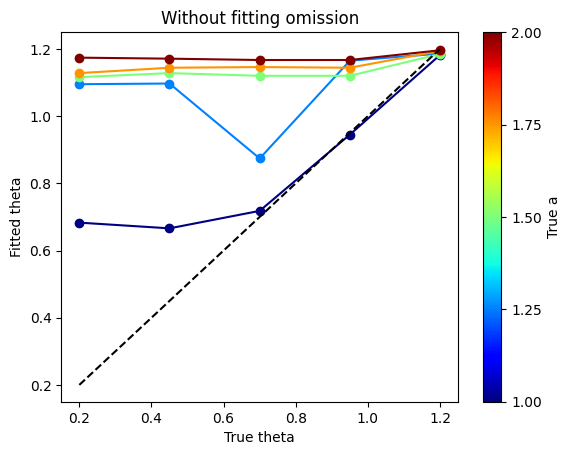

In [17]:
n_lines = len(a_list)
c = np.arange(1, n_lines + 1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=a_list[0], vmax=a_list[4])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
"""
fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))
fig.colorbar(cmap, ticks=c)
plt.show();
"""
fig, ax = plt.subplots(dpi=100)
for i,a in enumerate(a_list):
    mask = np.array(a_true)==a
    theta_true_sub = np.array(theta_true)[mask]
    theta_pred_nd_sub = np.array(theta_pred_nd)[mask]
    #plt.scatter(a_true_sub,a_pred_d_sub)
    ax.plot(theta_true_sub,theta_pred_nd_sub,linestyle='-', marker='o',color=cmap.to_rgba(a))
plt.colorbar(cmap,ax=ax,ticks=a_list,label='True a')
ax.plot(theta_true_sub,theta_true_sub,linestyle='--', color='black')
plt.xlabel('True theta')
plt.ylabel('Fitted theta')
plt.title('Without fitting omission')
plt.show()